### Imports

In [1]:
import xarray as xr
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def detrend(da):
    da.values[np.isnan(da.values)] = 0.0
    return signal.detrend(da,axis=0)  

### Read Data, Select times, Reverse lats

In [3]:
fname = '/scratch/kpegion/sst.mon.mean.COBE.nc'
ds = xr.open_dataset(fname,decode_times=True).sel(time=slice('1880-01','2017-12'))
ds=ds.reindex(lat=list(reversed(ds['lat'])))
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

### Make anomalies

In [4]:
ds_climo = ds.sel(time=slice('1980-01-01','2009-12-01')).groupby('time.month').mean(dim='time')
ds_anom = ds.groupby('time.month') - ds_climo

In [5]:
ds_anom

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 0.0527 0.0527 0.05317

In [6]:
ds_anom['sst'].sel(time='1880-11-01',lat=0,lon=180,method='nearest')

<xarray.DataArray 'sst' ()>
array(-0.23456764, dtype=float32)
Coordinates:
    lat      float64 0.5
    lon      float32 180.5
    time     datetime64[ns] 1880-11-01
    month    int64 11

### Detrend and put back into `xr.Dataset`

In [7]:
anoms_detrend = detrend(ds_anom['sst'])

ds_tmp=xr.DataArray(anoms_detrend,
                    coords={'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                    dims=['time','lat','lon'])        
ds_anom_detrend=ds_tmp.to_dataset(name='sst')
ds_anom_detrend

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.02829 0.02819 0.02862

In [8]:
ds_anom_detrend['sst'].sel(time='1880-11-01',lat=0,lon=180,method='nearest')

<xarray.DataArray 'sst' ()>
array(0.34970945, dtype=float32)
Coordinates:
    time     datetime64[ns] 1880-11-01
    lat      float64 0.5
    lon      float32 180.5

### Checks

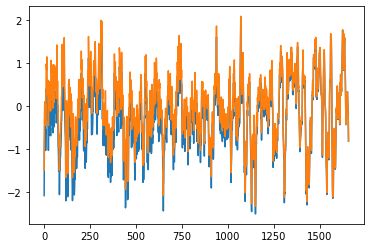

In [9]:
plt.plot(ds_anom['sst'].sel(lon=180,lat=0,method='nearest'))
plt.plot(ds_anom_detrend['sst'].sel(lon=180,lat=0,method='nearest'))

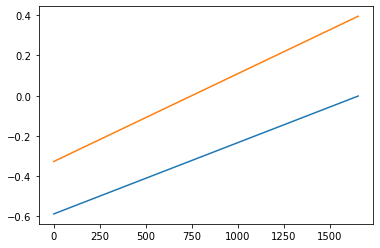

In [10]:
diff=ds_anom['sst']-ds_anom_detrend['sst']
plt.plot(diff.sel(lon=180,lat=0,method='nearest'))
plt.plot(diff.sel(lon=180,lat=40,method='nearest'))

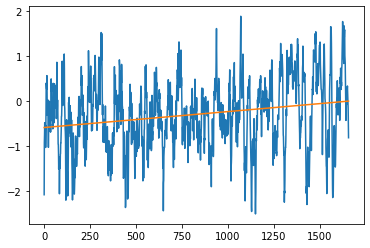

In [11]:
plt.plot(ds_anom['sst'].sel(lon=180,lat=0,method='nearest'))
plt.plot(diff.sel(lon=180,lat=0,method='nearest'))

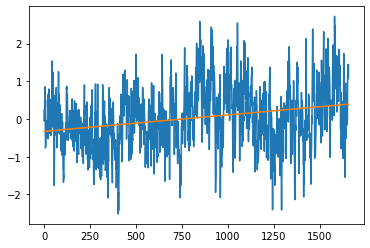

In [12]:
plt.plot(ds_anom['sst'].sel(lon=180,lat=40,method='nearest'))
plt.plot(diff.sel(lon=180,lat=40,method='nearest'))

In [13]:
nino_reg=ds_anom_detrend.sel(lat=slice(-5,5),lon=slice(360-170,360-120))
nino_reg

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 50, time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
  * lat      (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon      (lon) float32 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Data variables:
    sst      (time, lat, lon) float32 -1.118 -1.139 -1.145 ... -0.5604 -0.594

### Make Nino3.4

In [14]:
ds_nino = ds_anom_detrend.sel(lat=slice(-5,5),lon=slice(360-170,360-120)).mean(dim=['lat','lon'])
ds_nino

<xarray.Dataset>
Dimensions:  (time: 1656)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2017-12-01
Data variables:
    sst      (time) float32 -1.808 -0.3871 -0.3249 ... -0.4857 -0.711 -1.056

In [15]:
elnino=ds_nino['sst'].where(ds_nino['sst']>0.5)
lanina=ds_nino['sst'].where(ds_nino['sst']<-0.5)

### Toms et al. has El Nino = 337; La Nina=485?

In [16]:
print('El Nino: ',elnino.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

El Nino:  410
La Nina:  435


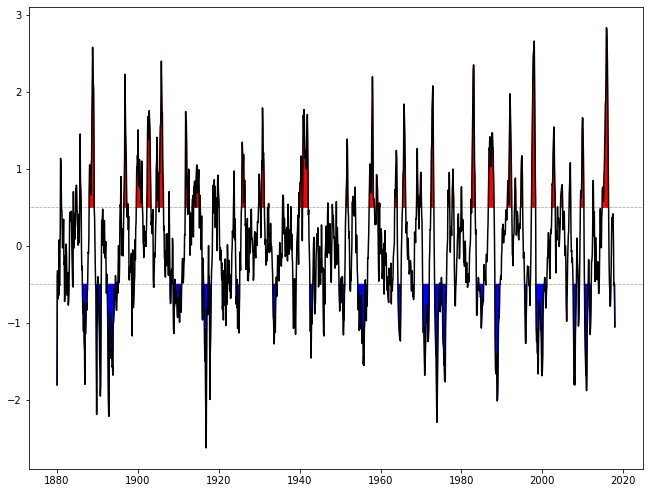

In [17]:
plt.figure(figsize=(11,8.5))
plt.plot(ds_nino['time'],ds_nino['sst'],'k')
plt.fill_between(ds_nino['time'],0.5,elnino,color='red')
plt.fill_between(ds_nino['time'],lanina, -0.5,color='blue')
plt.axhline(0.5,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.5,color='black',linewidth=0.5,linestyle='dotted')

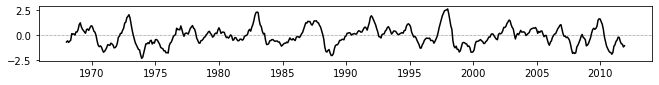

In [24]:
tmp=ds_nino.sel(time=slice('1968-01','2011-12'))
plt.figure(figsize=(11,1.0))
plt.plot(tmp['time'],tmp['sst'],'k')
plt.axhline(0.0,color='black',linewidth=0.5,linestyle='dotted')

### Make Composite

In [ ]:
comp_elnino=ds_anom_detrend.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')

In [ ]:
from cartopy.util import add_cyclic_point

clevs=np.arange(-1.5,1.6,0.1)
fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=230))
data, lons = add_cyclic_point(comp_elnino['sst'], coord=ds['lon'])
cs=ax.contourf(lons, ds['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='coolwarm',
               extend='both')
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax.coastlines()
ax.set_title('Composite El Nino')
plt.colorbar(cs,orientation='horizontal',label='SST Anomaly (deg C)')